### Add path to structure learning library (skip if installed via pip)

In [1]:
import sys
sys.path.append('../src')

### Import relevant classes, set random seed

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from structure_learning.data import SyntheticDataset, Data
from structure_learning.data_structures import DAG
from structure_learning.scores import BGeScore
from structure_learning.distributions import Distribution
from structure_learning.experiments import Experiment
from structure_learning.evaluation.metrics import RHat
# for reproducibility
np.random.seed(100)

### 1. Setup experiment by defining an instance of Experiment class

In [3]:
# setup synthetic data
num_nodes = 5
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 200
degree = 2

synthetic_data = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)

00010 00100 10000 00000 01010


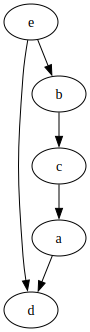

In [4]:
# visualise ground truth DAG
synthetic_data.graph.plot()

In [5]:
true_dist = Distribution.compute_distribution(data=synthetic_data.data, score=BGeScore, graph_type='dag')

np.save('true_distribution.npy', true_dist)

In [6]:

np.save('cpdag.npy', synthetic_data.graph.to_cpdag())

#### configurations of samplers to run

In [37]:
samplers = [
    {
        "sampler_type": "StructureMCMC",
        "n_chains": 2,
        "config": {
            "max_iter": 100000,
            "score_object": "bge",
            "pc_init": False,
            "result_type": "opad+",
            "graph_type": "dag",
        }
    },
    {
        "sampler_type": "PartitionMCMC",
        "n_chains": 2,
        "config": {
            "max_iter": 100000,
            "score_object": "bge",
            "result_type": "opad+",
            "graph_type": "dag",
            "searchspace": "FULL"
        }
    }
]

#### run the experiment

In [38]:
exp = Experiment(experiment_name='test', data=synthetic_data.data, samplers=samplers, ground_truth='true_distribution.npy', metrics=['mae', 'mse', 'rhat', 'kld', 'jsd'], n_threads=8, seed=42)
res = exp.run()

Adding rejected particles
Adding rejected particles
Adding rejected particles
Adding rejected particles


#### evaluate

In [39]:
exp.evaluate()

{'mae': [1.2828660619014782e-07,
  2.983188971488311e-07,
  3.310140664526036e-08,
  6.446439617595333e-08],
 'mse': [9.761359700745817e-12,
  5.2576786370908634e-11,
  7.048800887678745e-13,
  2.6034480286006714e-12],
 'rhat': 1.000020565855062,
 'kld': [0.0018795658103758733,
  0.004376670297524617,
  0.0004845049618329843,
  0.0009439409523800154],
 'jsd': [0.0006511621760412097,
  0.0015158266948146694,
  0.000167856368474505,
  0.00032704209754543846]}

#### plot distributions

/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/distributions/distribution.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(a_melt['index'], rotation=90)


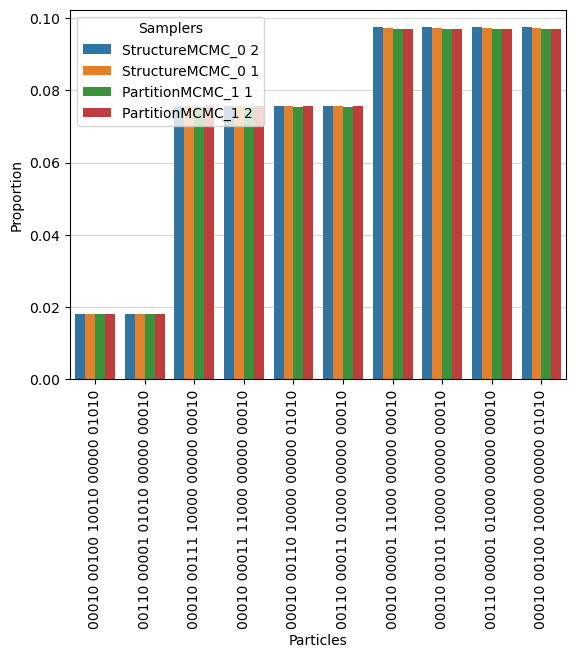

In [40]:

sampler_types = [f'{sampler['sampler_type']}_{idx} {i+1}' for idx, sampler in enumerate(samplers) for i in range(sampler['n_chains'])]
_ = Distribution.plot_multiple([r[0] for r in res if isinstance(r[0], Distribution)], prop='p', labels=sampler_types, limit=10)

In [41]:
### create yaml file for the experiment
yaml_content = exp.to_yaml('test.yaml')
yaml_content